In [2]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/spaghetti/src
/home/akarsh_sakana_ai/.conda/envs/spaghetti/bin/python


In [3]:
import os
from functools import partial

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.random import split

from flax import linen as nn
from flax.training.train_state import TrainState
import optax

import jax
import jax.numpy as jnp
from jax.random import split
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from einops import rearrange, repeat

from clip import CLIP
from cppn import CPPN, FlattenCPPNParameters
import util


In [4]:
clip = CLIP()

In [9]:
def loss_fn(img):
    return clip.embed_img(img).mean()
    # return img.mean()

grad_fn = jax.jit(jax.value_and_grad(loss_fn))

for t in tqdm(range(1000)):
    a = jnp.zeros((224, 224, 3))
    grad_fn(a)



  0%|          | 0/1000 [00:00<?, ?it/s]

2025-01-14 04:02:56.697350: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng35{k2=1,k5=2,k14=5} for conv %cudnn-conv.4 = (f32[3,224,224,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,32,32,768]{3,2,1,0} %bitcast.18934, f32[1,193,193,768]{3,2,1,0} %bitcast.22920), window={size=193x193 pad=192_192x192_192 rhs_reversal=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", metadata={op_name="jit(loss_fn)/jit(main)/transpose(jvp(vision_model))/embeddings/patch_embedding/conv_general_dilated" source_file="/home/akarsh_sakana_ai/spaghetti/src/clip.py" source_line=23}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-01-14 04:03:07.840925: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 12.143682249s
Trying algorithm eng35{k2=1,

KeyboardInterrupt: 

In [122]:
import argparse
parser = argparse.ArgumentParser()
group = parser.add_argument_group("meta")
group.add_argument("--seed", type=int, default=0, help="the random seed")
group.add_argument("--save_dir", type=str, default=None, help="path to save results to")

group = parser.add_argument_group("optimization")
group.add_argument("--n_iters", type=int, default=100000, help="")
group.add_argument("--pop_size", type=int, default=128, help="")
group.add_argument("--bs", type=int, default=32, help="")
group.add_argument("--sigma", type=float, default=.1, help="mutation rate")

def parse_args(*args, **kwargs):
    args = parser.parse_args(*args, **kwargs)
    for k, v in vars(args).items():
        if isinstance(v, str) and v.lower() == "none":
            setattr(args, k, None)  # set all "none" to None
    return args

args = parse_args('')

In [3]:
fm = clip.CLIP()

In [123]:
with open('../nounlist.txt', 'r') as f:
    nouns = f.read().strip().split('\n')
nouns = nouns[:args.pop_size]
assert args.pop_size % args.bs == 0

fm = clip.CLIP()
z_txt = fm.embed_txt(nouns)

z_txt_quality = fm.embed_txt("a high quality image")[0]
print(z_txt.shape)
print(z_txt_quality.shape)


(128, 512)
(512,)


In [ ]:
cppn = CPPN(n_layers=4, d_hidden=16)
cppn = FlattenCPPNParameters(cppn)

rng = jax.random.PRNGKey(args.seed)
x = jnp.zeros((3,))

params = jax.random.normal(rng, (args.pop_size, cppn.n_params))

@jax.jit
def get_pheno(params):
    img = cppn.generate_image(params)
    z_img = fm.embed_img(img) # (D, )

    bc = (z_img @ z_txt.T).argmax() # index of best caption
    quality = z_img @ z_txt_quality
    return dict(params=params, img=img, z_img=z_img, bc=bc, quality=quality)

# def scan_fn(_, params):
    # return None, get_pheno(params)

def add_pheno_to_archive(archive, pheno):
    idx = pheno['bc']
    if pheno['quality'] > archive[idx]['quality']:
        archive[idx] = pheno
        return True
    return False

archive = [get_pheno(p) for p in tqdm(params)]
for a in archive:
    a['quality'] = -np.inf

for pi in tqdm(params):
    add_pheno_to_archive(archive, get_pheno(pi))


ParameterReshaper: 931 parameters detected for optimization.


  0%|          | 0/128 [00:00<?, ?it/s]

In [97]:
# plt.imshow(rearrange(archive['img'][:16], "(R C) H W D -> (R H) (C W) D", R=4))

In [98]:
def do_iter(rng, archive):
    idx = np.random.randint(0, args.pop_size)
    params_parent = archive[idx]['params']

    params_children = params_parent + 0.1 * jax.random.normal(rng, params_parent.shape)

    pheno = get_pheno(params_children)
    replaced = add_pheno_to_archive(archive, pheno)
    return replaced

transfers = 0

pbar = tqdm(range(args.n_iters))
for i in pbar:
    rng, _rng = split(rng)
    replaced = do_iter(_rng, archive)
    if replaced:
        transfers += 1
    pbar.set_postfix(transfers=transfers)


  0%|          | 0/100000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'abbey')

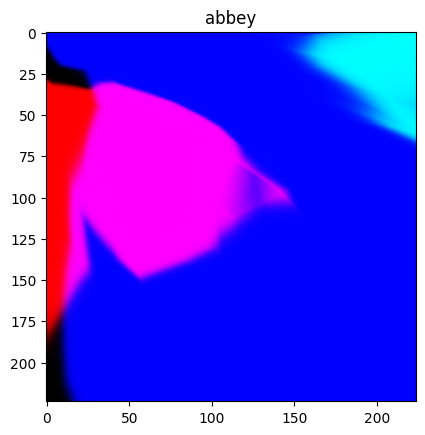

In [ ]:
plt.imshow(archive[6]['img'])
plt.title(nouns[6])

In [109]:
np.array([a['quality'] for a in archive])

array([      -inf, 0.27874407, 0.25929594, 0.25537649, 0.26693392,
             -inf,       -inf, 0.23970789, 0.25602275,       -inf,
             -inf, 0.25414103, 0.27166697, 0.26441973, 0.26563877,
             -inf, 0.23238003, 0.22737405,       -inf, 0.28065452,
       0.24114625, 0.2538974 ,       -inf,       -inf,       -inf,
       0.26035663,       -inf, 0.24098083, 0.23592407,       -inf,
       0.25645772,       -inf, 0.25093025,       -inf,       -inf,
             -inf, 0.2289644 ,       -inf, 0.26305294, 0.23993151,
             -inf, 0.27953449,       -inf, 0.27608865,       -inf,
       0.26980671,       -inf,       -inf, 0.26896629,       -inf,
             -inf, 0.27222583,       -inf,       -inf, 0.25159472,
       0.24849153,       -inf, 0.25195765,       -inf, 0.24629493,
             -inf,       -inf, 0.24642986, 0.24332051,       -inf,
             -inf,       -inf,       -inf,       -inf,       -inf,
       0.26289788,       -inf, 0.2435628 ,       -inf, 0.23759

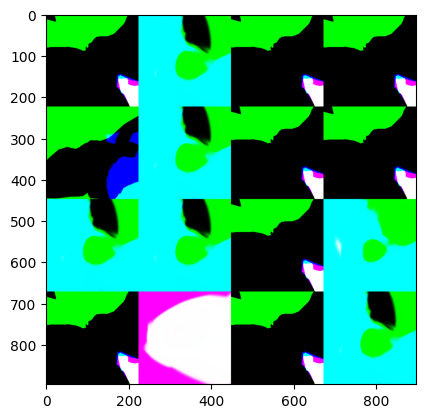

In [ ]:
plt.imshow(rearrange(archive['img'][:16], "(R C) H W D -> (R H) (C W) D", R=4))

In [27]:
cppn = CPPN(n_layers=6, d_hidden=128)
cppn = FlattenCPPNParameters(cppn)

z_txt = fm.embed_txt("a cat")[0]

def get_pheno(params):
    img = cppn.generate_image(params)
    z_img = fm.embed_img(img) # (D, )
    score = z_img @ z_txt
    return dict(params=params, img=img, z_img=z_img, score=score)

@jax.jit
def do_iter(rng, pop):
    idx = jnp.argsort(pop['score'])[::-1]
    idx = idx[:32]

    elites = jax.tree.map(lambda x: x[idx], pop)
    idx = jax.random.randint(rng, (128), 0, 32)
    parents = jax.tree.map(lambda x: x[idx], pop)
    params = parents['params'] + 0.01 * jax.random.normal(rng, parents['params'].shape)
    params = params.at[0].set(elites['params'][0])
    pop = jax.vmap(get_pheno)(params)
    return pop

rng = jax.random.PRNGKey(3)
pop = jax.vmap(get_pheno)(jax.random.normal(rng, (128, cppn.n_params)))

pbar = tqdm(range(10000))
fitness = []
for i in pbar:
    best_fitness = pop['score'].max().item()
    fitness.append(best_fitness)
    pbar.set_postfix(best_fitness=best_fitness)

    rng, _rng = split(rng)
    pop = do_iter(rng, pop)

ParameterReshaper: 83459 parameters detected for optimization.


  0%|          | 0/10000 [00:00<?, ?it/s]

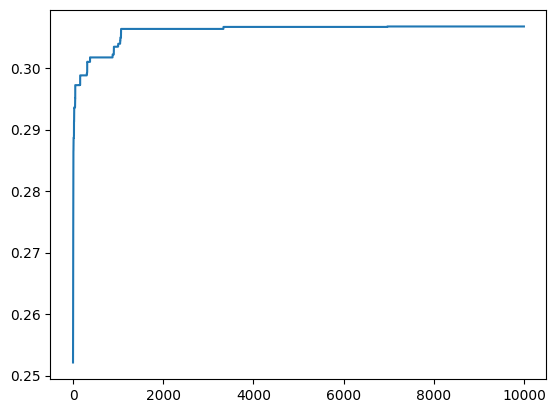

In [28]:
plt.plot(fitness)

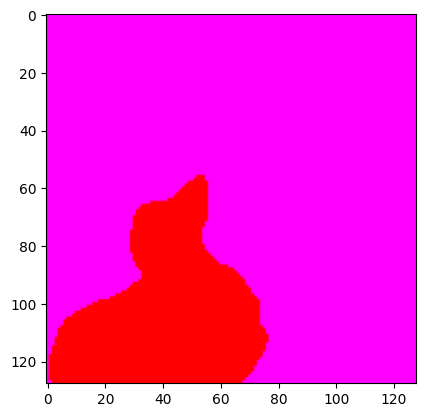

In [29]:
plt.imshow(pop['img'][0])

In [49]:
cat_img = plt.imread("dog.jpg")/255.
cat_img = jax.image.resize(cat_img, (224, 224, 3), method='bilinear')

In [50]:
cat_img.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00048321823..1.0000001].


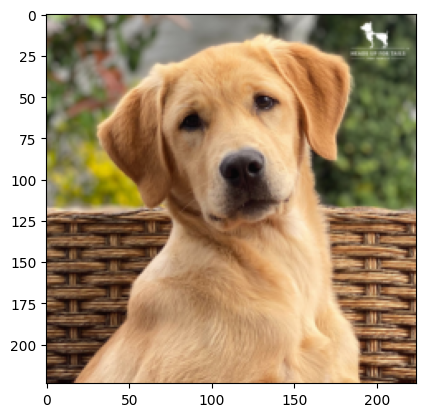

In [51]:
plt.imshow(cat_img)

In [52]:
z_img = fm.embed_img(cat_img)

In [53]:
(z_img * z_txt).sum(axis=-1)

Array(0.18917452, dtype=float32)

In [45]:
z_txt = fm.embed_txt("a cat")[0]

ParameterReshaper: 931 parameters detected for optimization.
931


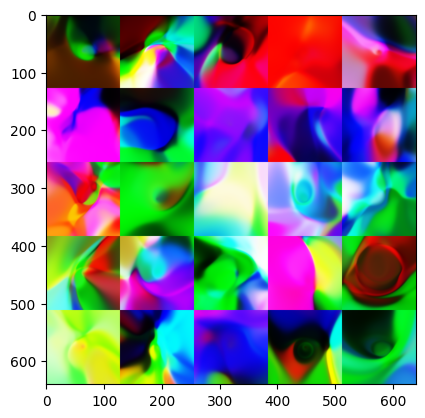

In [28]:
cppn = CPPN(n_layers=4, d_hidden=16, nonlin='tanh')
cppn = FlattenCPPNParameters(cppn)
rng = jax.random.PRNGKey(0)
params = jax.random.normal(rng, (25, cppn.n_params))
print(cppn.n_params)


imgs = jax.vmap(cppn.generate_image)(params)
plt.imshow(rearrange(imgs, "(R C) H W D -> (R H) (C W) D", R=5))

In [31]:
import argparse
parser = argparse.ArgumentParser()
group = parser.add_argument_group("meta")
group.add_argument("--seed", type=int, default=0, help="the random seed")
group.add_argument("--save_dir", type=str, default=None, help="path to save results to")

group = parser.add_argument_group("optimization")
group.add_argument("--n_iters", type=int, default=100000, help="")
group.add_argument("--pop_size", type=int, default=4096, help="")
group.add_argument("--bs", type=int, default=32, help="")
group.add_argument("--sigma", type=float, default=.1, help="mutation rate")

def parse_args(*args, **kwargs):
    args = parser.parse_args(*args, **kwargs)
    for k, v in vars(args).items():
        if isinstance(v, str) and v.lower() == "none":
            setattr(args, k, None)  # set all "none" to None
    return args

args = parse_args('')

In [47]:
with open('../nounlist.txt', 'r') as f:
    nouns = f.read().strip().split('\n')

nouns = nouns[:args.pop_size]
assert args.pop_size % args.bs == 0

fm = clip.CLIP()
z_txt = fm.embed_txt(nouns)

cppn = CPPN(n_layers=4, d_hidden=16, nonlin='tanh')
cppn = FlattenCPPNParameters(cppn)

rng = jax.random.PRNGKey(args.seed)

def get_pheno(params):
    img = cppn.generate_image(params)
    z_img = fm.embed_img(img)
    return dict(params=params, img=img, z_img=z_img)

def get_niche(archive, pheno):
    return jnp.argmax(pheno['z_img'] @ archive['z_txt'].T)

def calc_quality(archive, nid, pheno):
    return archive['z_txt'][nid] @ pheno['z_img']

def mutate(rng, params):
    return params


def place_in_archive(archive, pheno):
    archive = jax.tree.map(lambda x: x, archive) # copy

    nid = get_niche(archive, pheno)
    current_pheno = jax.tree.map(lambda x: x[nid], archive['pheno'])

    current_quality = archive['quality'][nid]
    quality = calc_quality(archive, nid, pheno)
    replace = quality > current_quality
    new_pheno = jax.tree.map(lambda x, y: jnp.where(replace, x, y), pheno, current_pheno)
    new_quality = jnp.where(replace, quality, current_quality)
    print(new_quality)
    archive['pheno'] = jax.tree.map(lambda x, y: x.at[nid].set(y), archive['pheno'], new_pheno)
    archive['quality'] = archive['quality'].at[nid].set(new_quality)
    data = dict(pheno=pheno, nid=nid, replace=replace)
    return archive, data

# @jax.jit
def do_iter(rng, archive):
    p = (archive['quality'] > -jnp.inf).astype(jnp.float32)
    p = p / p.sum()

    rng, _rng = split(rng)
    idx_parent = jax.random.choice(_rng, args.pop_size, shape=(), p=p)
    params_parent = archive['pheno']['params'][idx_parent]
    rng, _rng = split(rng)
    params_child = mutate(_rng, params_parent)

    pheno_child = get_pheno(params_child)
    archive, data = place_in_archive(archive, pheno_child)
    return archive, data


ParameterReshaper: 931 parameters detected for optimization.


In [46]:
pheno = get_pheno(jax.random.normal(rng, (cppn.n_params, )))
archive = dict(
    z_txt=z_txt,
    pheno=jax.tree.map(lambda x: repeat(x, "... -> N ...", N=args.pop_size), pheno),
    quality=jnp.full((args.pop_size,), -jnp.inf),
)
print('archive', jax.tree.map(lambda x: x.shape, archive))
print((archive['quality']>-jnp.inf).sum())
archive, data = place_in_archive(archive, pheno)
print((archive['quality']>-jnp.inf).sum())
# print(data)

# archive = do_iter(rng, archive)

archive {'pheno': {'img': (4096, 128, 128, 3), 'params': (4096, 931), 'z_img': (4096, 512)}, 'quality': (4096,), 'z_txt': (4096, 512)}
0
0.3006928
1


In [48]:
archive

{'pheno': {'img': Array([[[[6.3967168e-01, 1.1612806e-03, 1.9828995e-01],
           [6.4009815e-01, 1.1424120e-03, 2.0178984e-01],
           [6.4062512e-01, 1.1212950e-03, 2.0505492e-01],
           ...,
           [1.8053614e-01, 2.9833283e-05, 9.3034095e-01],
           [1.9097753e-01, 2.8656075e-05, 9.2296636e-01],
           [1.9887410e-01, 2.7823598e-05, 9.1762012e-01]],
  
          [[6.3957822e-01, 1.1601986e-03, 1.9804429e-01],
           [6.3998532e-01, 1.1481183e-03, 2.0084955e-01],
           [6.4064360e-01, 1.1232841e-03, 2.0451640e-01],
           ...,
           [1.8403830e-01, 2.9426736e-05, 9.2811018e-01],
           [1.9323288e-01, 2.8395172e-05, 9.2156518e-01],
           [2.0033030e-01, 2.7632101e-05, 9.1653633e-01]],
  
          [[6.3946313e-01, 1.1669386e-03, 1.9747843e-01],
           [6.3995391e-01, 1.1522066e-03, 2.0030928e-01],
           [6.4088106e-01, 1.1189646e-03, 2.0484774e-01],
           ...,
           [1.8648154e-01, 2.9111245e-05, 9.2631185e-01],


In [7]:
with open('../nounlist.txt', 'r') as f:
    nouns = f.read().strip().split('\n')

nouns = nouns[:6800]

In [5]:
archive = util.load_pkl('.', 'archive2')

In [5]:
plt.figure(figsize=(50, 70))
iplt = 0
img_data = [(archive['pheno']['img'][i], archive['quality'][i], nouns[i]) for i in range(6800) if archive['quality'][i] > -jnp.inf]
print(len(img_data))
for i in tqdm(range(3000)):
    img, quality, noun = img_data[i]
    iplt += 1
    plt.subplot(50, 60, iplt)
    plt.imshow(img);plt.axis('off')
    plt.title(f"{noun}\n{quality:.3f}")
plt.tight_layout()
plt.savefig('archive2.png')
plt.close()

6800


  0%|          | 0/3000 [00:00<?, ?it/s]

In [6]:
data = util.load_pkl('.', 'data2')
# data = data[::100]
data = jax.tree.map(lambda *x: np.stack(x, axis=0), *data)

In [7]:
data.keys()

dict_keys(['n_replacements', 'nid_parent'])

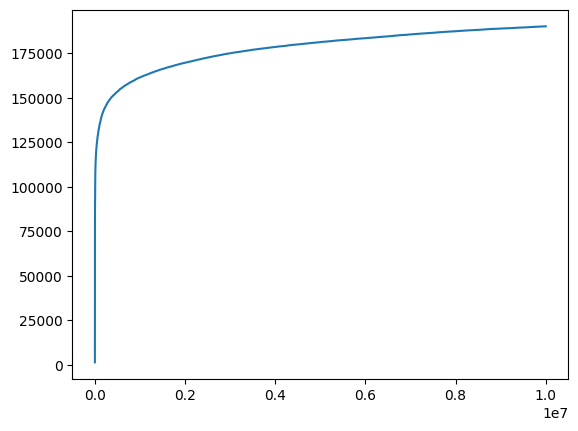

In [27]:
plt.plot(np.cumsum(data['n_replacements']))

In [21]:
data = util.load_pkl('.', 'data')
data = data[::100]
data = jax.tree.map(lambda *x: np.stack(x, axis=0), *data)

In [22]:
data.keys()

dict_keys(['nid', 'nid_before', 'replace'])

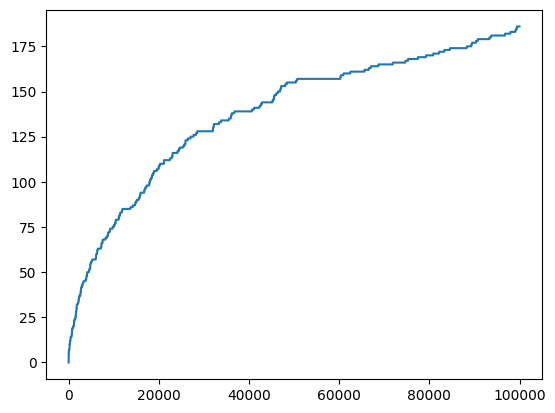

In [25]:
plt.plot(np.cumsum(data['replace']))

In [26]:
data['replace'].mean()

np.float64(0.00186)

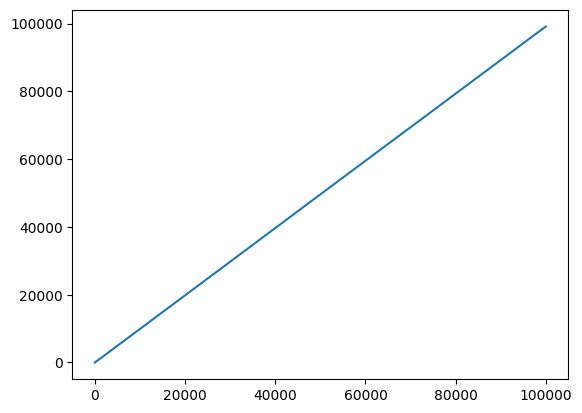

In [31]:
plt.plot(np.cumsum(data['nid']!=data['nid_before']))

ParameterReshaper: 931 parameters detected for optimization.


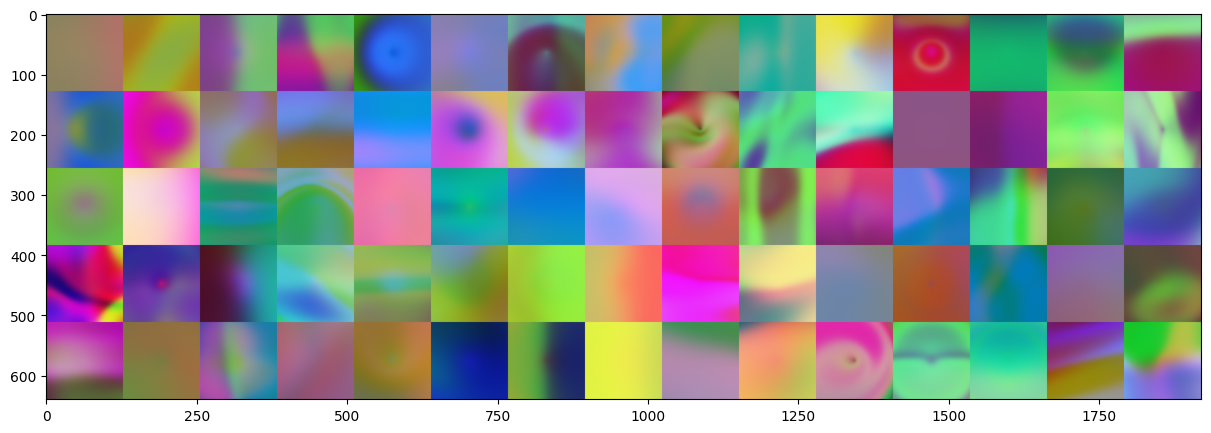

In [49]:

def gaussian(x):
    return jnp.exp(-4*x**2)

class CPPN(nn.Module):
    n_layers: int
    d_hidden: int
    nonlin: str = 'tanh' # use tanh or relu

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(self.d_hidden)(x)
            # x = getattr(nn, self.nonlin)(x)
            x = jnp.sin(x)
            # x = gaussian(x)
        x = nn.Dense(3)(x)
        return jax.nn.sigmoid(x)

    def generate_image(self, params):
        x = y = jnp.linspace(-1, 1, 128)
        x, y = jnp.meshgrid(x, y, indexing='ij')
        d = jnp.sqrt(x**2 + y**2)
        xyd = jnp.stack([x, y, d], axis=-1)
        rgb = jax.vmap(jax.vmap(partial(self.apply, params)))(xyd)
        return rgb


import evosax
class FlattenCPPNParameters():
    def __init__(self, cppn):
        self.cppn = cppn

        rng = jax.random.PRNGKey(0)
        x = jnp.zeros((3,))
        self.param_reshaper = evosax.ParameterReshaper(self.cppn.init(rng, x))
        self.n_params = self.param_reshaper.total_params
    
    def init(self, rng, x):
        params = self.cppn.init(rng, x)
        return self.param_reshaper.flatten_single(params)

    def generate_image(self, params):
        params = self.param_reshaper.reshape_single(params)
        return self.cppn.generate_image(params)
    

cppn = CPPN(n_layers=4, d_hidden=16)
cppn = FlattenCPPNParameters(cppn)

rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
params = jax.random.normal(_rng, (75, cppn.n_params))
rng, _rng = split(rng)
mask = jax.random.uniform(_rng, (75, cppn.n_params)) < 0.2
params = mask*params + (1-mask)*0.

imgs = jax.vmap(cppn.generate_image)(params)
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(imgs, "(R C) H W D -> (R H) (C W) D", R=5))



In [72]:
cppn = CPPN(n_layers=4, d_hidden=16, nonlin='tanh')
cppn = FlattenCPPNParameters(cppn)

ParameterReshaper: 931 parameters detected for optimization.


In [73]:
idx = nouns.index('person')

Text(0.5, 1.0, "Picbreeder image for 'person'")

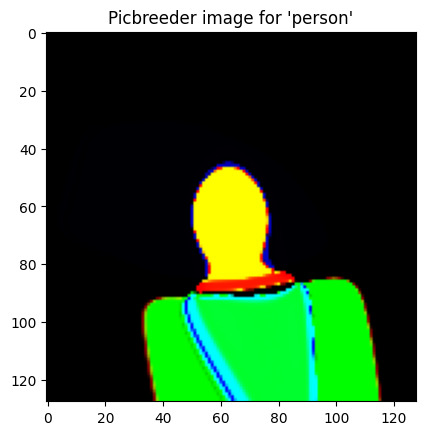

In [74]:
img = jax.tree.map(lambda x: x[idx], archive)['pheno']['img']
params = jax.tree.map(lambda x: x[idx], archive)['pheno']['params']
plt.imshow(img)
plt.title("Picbreeder image for 'person'")

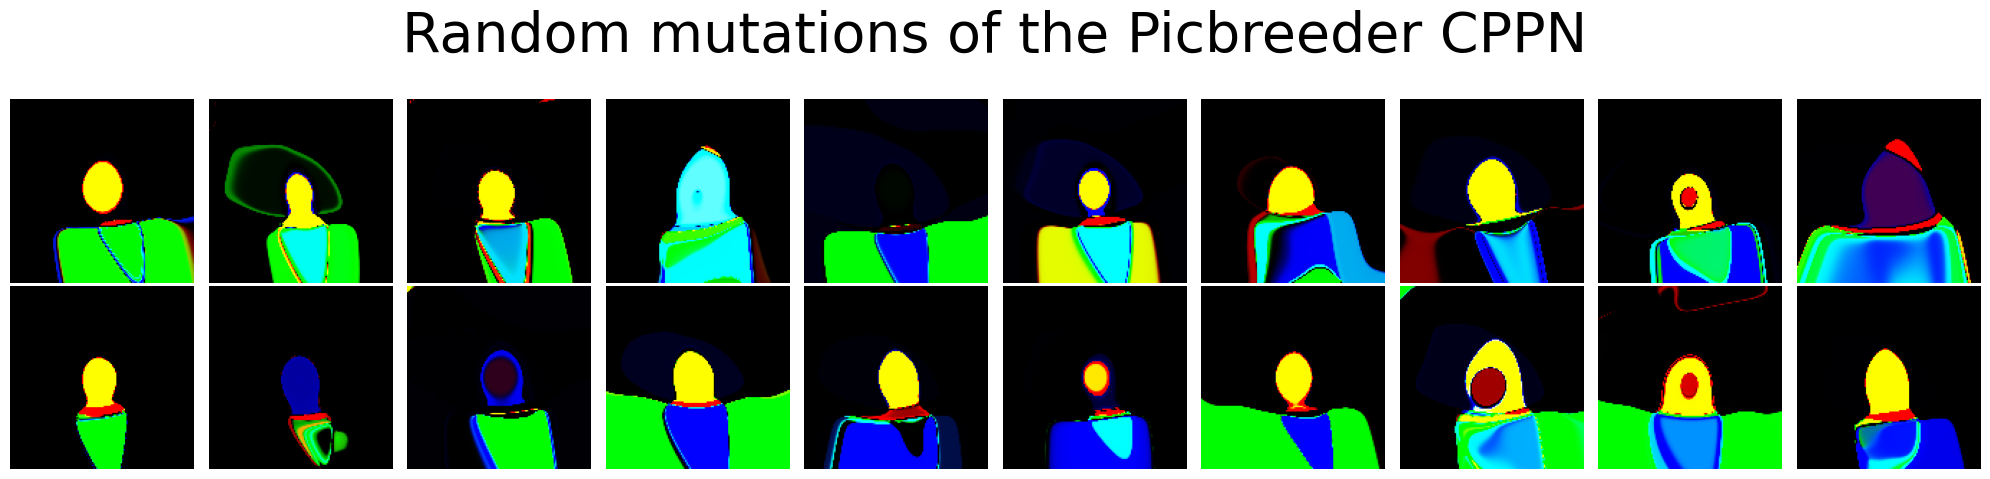

In [75]:
fig = plt.figure(figsize=(20, 5))
for i in range(20):
    rng = jax.random.PRNGKey(i)
    paramsp = params + 0.5 * jax.random.normal(rng, params.shape)
    imgp = cppn.generate_image(paramsp)
    plt.subplot(2, 10, i+1); plt.imshow(imgp); plt.axis('off')

plt.suptitle("Random mutations of the Picbreeder CPPN", fontsize=40)
plt.tight_layout()
plt.show()



In [76]:
def loss_fn(paramsp):
    imgp = cppn.generate_image(paramsp)
    return ((img-imgp)**2).mean()
grad_fn = jax.jit(jax.value_and_grad(loss_fn))

@jax.jit
def train_step(state):
    loss, grad = grad_fn(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

rng = jax.random.PRNGKey(0)
params_sgd = jax.random.normal(rng, params.shape)


tx = optax.adam(learning_rate=3e-4)
state = TrainState.create(apply_fn=None, params=params_sgd, tx=tx)

for t in tqdm(range(100000)):
    state, loss = train_step(state)
    if t % 10000 == 0:
        print(loss)

params_sgd = state.params

  0%|          | 0/100000 [00:00<?, ?it/s]

0.49903664
0.003963801
0.001467525
0.0013040103
0.0012513951
0.0012268466
0.0012055793
0.0011896427
0.0011816529
0.0011743247


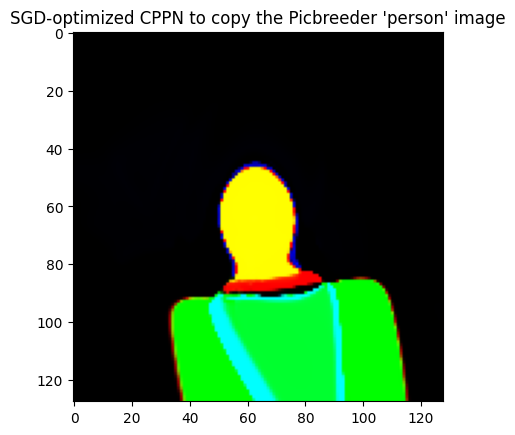

In [78]:
plt.imshow(cppn.generate_image(params_sgd))
plt.title("SGD-optimized CPPN to copy the Picbreeder 'person' image")
plt.show()

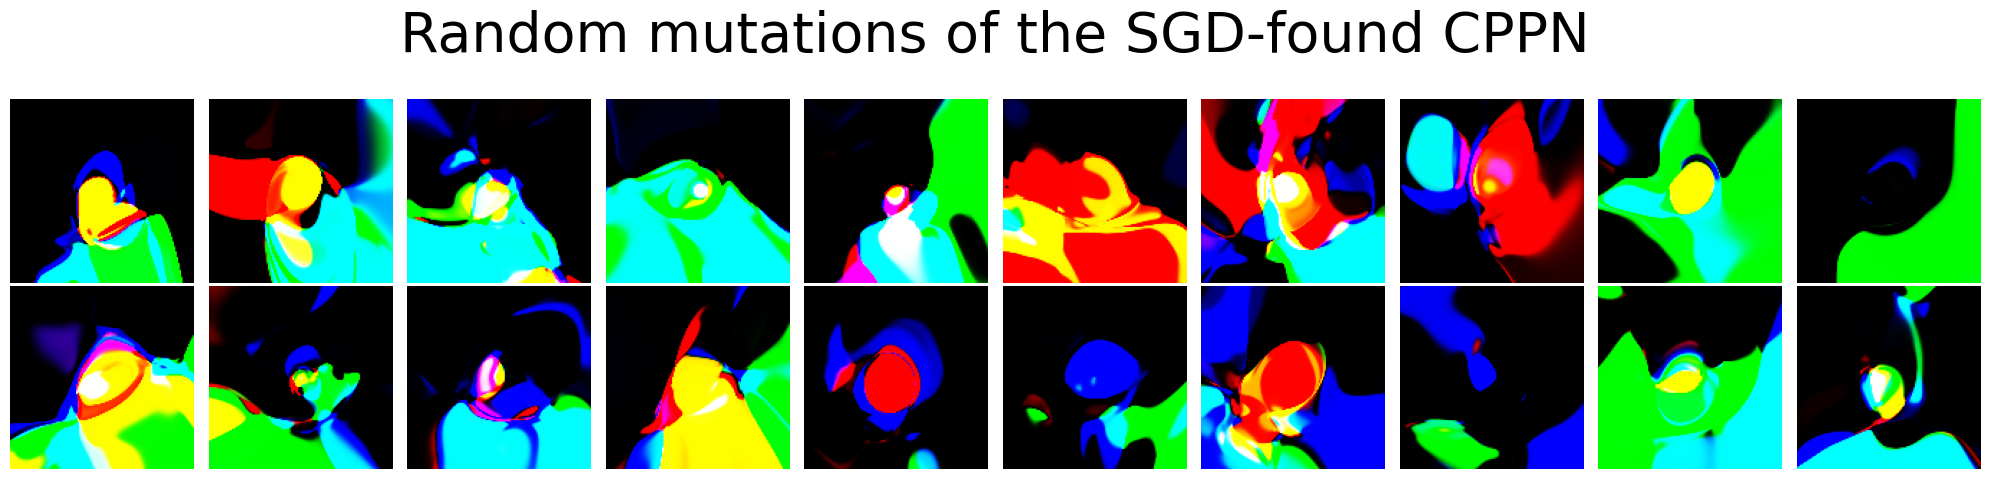

In [80]:
fig = plt.figure(figsize=(20, 5))
for i in range(20):
    rng = jax.random.PRNGKey(i)
    paramsp = params_sgd + 0.5 * jax.random.normal(rng, params.shape)
    imgp = cppn.generate_image(paramsp)
    plt.subplot(2, 10, i+1); plt.imshow(imgp); plt.axis('off')
plt.suptitle("Random mutations of the SGD-found CPPN", fontsize=40)
plt.tight_layout()
plt.show()
